In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from haversine import haversine

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we skip the subsampling step here.

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 of our entries list basement size as '?'. Since we have columns that measures square footage above basement and square footage, reassign square footage of basement with sqft_living - sqft_above.

In [5]:
mask = house_data['sqft_basement'] == '?'
house_data.loc[mask, 'sqft_basement'] = (house_data['sqft_living'] - house_data['sqft_above'])
house_data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,0,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [6]:
house_data['view'].isna().sum()

63

We have 63 NaN values for view. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Since so many values here are 0 and we don't want to make any unsafe assumptions, we elect to drop this column entirely.

In [9]:
house_data = house_data.drop('yr_renovated', axis=1)

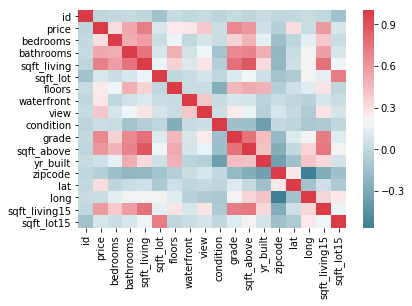

In [10]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [11]:
house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.017392,0.000991,0.004971,-0.012381,-0.132061,0.018573,-0.004872,0.011592,-0.023944,0.008331,-0.010967,0.021609,-0.008027,-0.002001,0.020637,-0.002707,-0.138607
price,-0.017392,1.000000,0.308063,0.525053,0.701587,0.090338,0.257052,0.270982,0.395734,0.035393,0.668307,0.605695,0.054273,-0.053620,0.307868,0.022417,0.585304,0.083189
bedrooms,0.000991,0.308063,1.000000,0.514368,0.577934,0.032735,0.177391,-0.004082,0.078523,0.026402,0.356095,0.479148,0.155462,-0.153990,-0.010415,0.132318,0.392874,0.030952
bathrooms,0.004971,0.525053,0.514368,1.000000,0.755277,0.088921,0.502285,0.064608,0.186451,-0.126682,0.665312,0.686173,0.507565,-0.204435,0.024487,0.225025,0.569139,0.088854
sqft_living,-0.012381,0.701587,0.577934,0.755277,1.000000,0.173768,0.353529,0.107416,0.282532,-0.059783,0.762398,0.876553,0.318217,-0.199839,0.052383,0.241856,0.756208,0.184801
sqft_lot,-0.132061,0.090338,0.032735,0.088921,0.173768,1.000000,-0.005025,0.023164,0.075298,-0.008375,0.115122,0.184325,0.052646,-0.129846,-0.085143,0.230137,0.145142,0.717095
floors,0.018573,0.257052,0.177391,0.502285,0.353529,-0.005025,1.000000,0.021399,0.028436,-0.264138,0.458694,0.523367,0.489410,-0.058966,0.049419,0.125329,0.279176,-0.010850
waterfront,-0.004872,0.270982,-0.004082,0.064608,0.107416,0.023164,0.021399,1.000000,0.406654,0.017175,0.085644,0.073500,-0.026612,0.031656,-0.012911,-0.040097,0.087257,0.031958
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023944,0.035393,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.017175,0.045735,1.000000,-0.147326,-0.158830,-0.361398,0.002125,-0.015594,-0.105475,-0.093172,-0.002702


Due to high collinearity with other variables, we choose to drop zipcode, sqft_above, and sqft_living15. Furthermore, we dropped grade because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms, which suggests high collinearity (as reflected in the numbers).

In [12]:
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [13]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 16 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       19164 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.8+ MB


In [14]:
# Waterfront has null values, since the number of nulls is a little high, fill with the highest categorical which is 0
house_data = house_data.fillna(0)

We want to see if the target is normally distributed as this is an assumption made with linear regression.

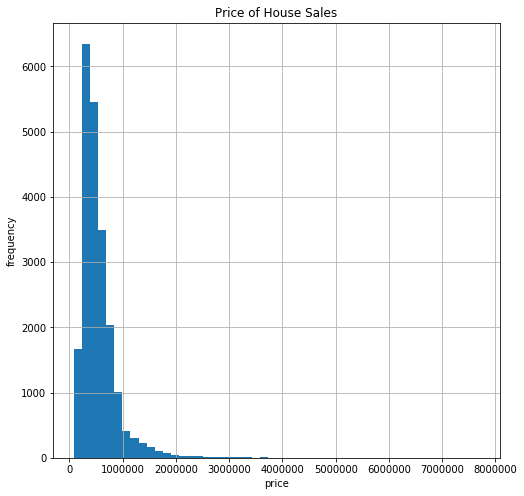

In [15]:
plt.figure(figsize=(8,8))
house_data['price'].hist(bins=50)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Price of House Sales')
plt.show()

Price is not normally distributed. A log transformation will be performed to rectify that.

In [16]:
house_data['log_price'] = house_data['price'].apply(lambda x: np.log(x))

In [17]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166


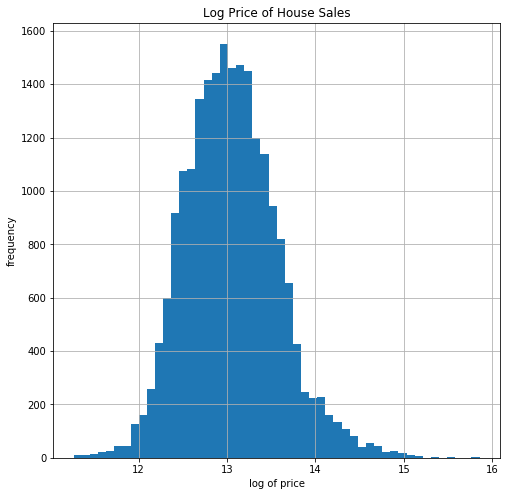

In [18]:
plt.figure(figsize=(8,8))
house_data['log_price'].hist(bins=50)
plt.xlabel('log of price')
plt.ylabel('frequency')
plt.title('Log Price of House Sales')
plt.show()

Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

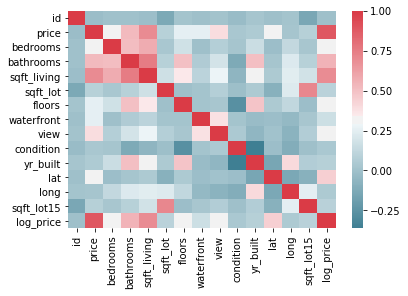

In [19]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

Most of our highly collinear variables are gone, great! But our remaining strongest predictors (e.g. bathrooms, bedrooms, and sqft_living) still have high collinearity with each other. In spite of this we decide to leave them, and resolve to test our model carefully to get the best accuracy we can without too much overfitting.

Our goal is to cater to as many potential house-buyers as possible. We therefore target the 90th percentile of home sale prices and disregard the rest to improve accuracy of the majority. We will show the accuracy once we get to building our models.

In [20]:
# we want to target our model to the majority of users, 
# but perhaps not to the people that are buying mansions/celebrities in the area
price_90th_perc = np.percentile(house_data['log_price'], 90)

house_data_90 = house_data.drop(house_data[house_data['log_price'] > price_90th_perc].index)

In [21]:
price_95th_perc = np.percentile(house_data['log_price'], 95)

house_data_95 = house_data.drop(house_data[house_data['log_price'] > price_95th_perc].index)

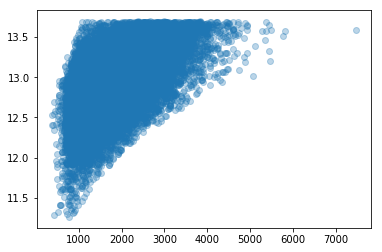

In [22]:
plt.scatter(house_data_90['sqft_living'], house_data_90['log_price'], alpha=0.3)

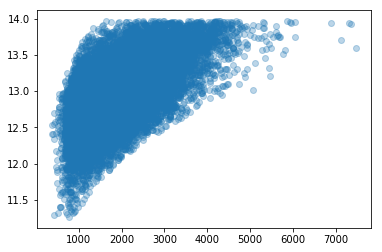

In [23]:
plt.scatter(house_data_95['sqft_living'], house_data_95['log_price'], alpha=0.3)

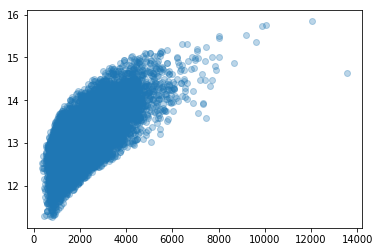

In [24]:
plt.scatter(house_data['sqft_living'], house_data['log_price'], alpha=0.3)

In [25]:
# remove strong outliers in sqft_living and bedrooms
house_data_90 = house_data_90.drop(house_data_90[house_data_90['sqft_living'] > 12000].index)
house_data_90 = house_data_90.drop(house_data_90[house_data_90['bedrooms']>30].index)

house_data_95 = house_data_95.drop(house_data_95[house_data_95['sqft_living'] > 12000].index)
house_data_95 = house_data_95.drop(house_data_95[house_data_95['bedrooms']>30].index)

house_data_100 = house_data.drop(house_data[house_data['sqft_living'] > 12000].index)
house_data_100 = house_data.drop(house_data[house_data['bedrooms']>30].index)

In [26]:
# get a simple linear regression model for price and sqft_living
x_90 = np.array(house_data_90['sqft_living'])
y_90 = np.array(house_data_90['log_price'])

x_95 = np.array(house_data_95['sqft_living'])
y_95 = np.array(house_data_95['log_price'])

x_100 = np.array(house_data_100['sqft_living'])
y_100 = np.array(house_data_100['log_price'])

In [27]:
def simple_linear_model(predictor, target, df):
    """Provides model the simple linear regression model between a predictor and target"""
    x = predictor
    y = target
    formula = 'y~x'
    model = ols(formula=formula, data=df).fit()
    return model.summary()

In [28]:
print(simple_linear_model(x_90, y_90, house_data_90))
print(simple_linear_model(x_95, y_95, house_data_95))
print(simple_linear_model(x_100, y_100, house_data_100))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8793.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:59:08   Log-Likelihood:                -6842.5
No. Observations:               19380   AIC:                         1.369e+04
Df Residuals:                   19378   BIC:                         1.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3209      0.007   1755.023      0.0

In [29]:
def test_median_err(predictors, target):
    """Train a model on the variables provided and return that model's MAE."""
    X = np.array(predictors)
    y = np.array(target)
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [30]:
sqft_living_mae_90 = test_median_err(x_90.reshape(-1,1), y_90.reshape(-1,1))
sqft_living_mae_95 = test_median_err(x_95.reshape(-1,1), y_95.reshape(-1,1))
sqft_living_mae_100 = test_median_err(x_100.reshape(-1,1), y_100.reshape(-1,1))

sqft_living_mae_90, sqft_living_mae_95, sqft_living_mae_100

(106645.31197874635, 111526.47035549101, 116530.41517076871)

After completing an initial model, it is easier to fit to the 90th percentile than to the 95th or 100th percentile of the data. 

In [31]:
# plt.figure(figsize=(8,8))
# plt.scatter(x_90,y_90, label='scatter', alpha = 0.3)
# plt.plot(x_90, y_hat_90, color='red', label='linear regression')
# plt.title('Square foot of living and their log(prices)')
# plt.legend()
# plt.xlabel('square footage of living space')
# plt.ylabel('log(price)')
# plt.show()

In [32]:
# Convert date strings to datetime. May work with this later.

In [33]:
from datetime import datetime

house_data_90['date'] = pd.to_datetime(house_data['date'])
house_data_90['date'].sort_values().head()

16302   2014-05-02
2485    2014-05-02
16909   2014-05-02
8883    2014-05-02
3320    2014-05-02
Name: date, dtype: datetime64[ns]

What follows are our experiments with a preliminary multivariate model.

In [34]:
outcome = 'log_price'
predictors = house_data_90.loc[:, ['sqft_living', 'yr_built', 'bedrooms', 'bathrooms', 'view']]
predictors_int = sm.add_constant(predictors)
model = sm.OLS(np.asarray(house_data_90['log_price']), np.asarray(predictors_int)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2202.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:59:10   Log-Likelihood:                -6107.4
No. Observations:               19380   AIC:                         1.223e+04
Df Residuals:                   19374   BIC:                         1.227e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3267      0.196     93.539      0.000      17.943      18.711
x1             0.0003   5.16e-06     61.225      0.000       0.000       0.000
x2            -0.0031      0.000    -30.419      0.000      -0.003      -0.003
x3            -0.0639      0.003    -18.272      0.000      -0.071      -0.057
x4             0.1367      0.006     24.582      0.000       0.126       0.148
x5             0.0535      0.004     12.894      0.000       0.045       0.062
==============================================================================
Omnibus:                      277.494   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.494
Skew:                          -0.285   Prob(JB):                     2.75e-62
Kurtosis:                       2.837   Cond. No.                     2.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
X_train, X_test, y_train, y_test = train_test_split(predictors, house_data_90['log_price'], test_size=0.3)

In [36]:
m_linreg = LinearRegression()

m_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
m_linreg.coef_

array([ 0.00031767, -0.00303951, -0.0630537 ,  0.13572136,  0.05442677])

In [38]:
m_linreg.intercept_

18.245482992311498

In [39]:
y_hat_train = np.exp(m_linreg.predict(X_train))
y_hat_test = np.exp(m_linreg.predict(X_test))

In [40]:
test_mae = median_absolute_error(y_test,y_hat_test)

print('test: ' + str(test_mae))

test: 405079.74658459914


In [41]:
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(m_linreg, predictors, house_data_90['log_price'], cv=5, scoring='neg_median_absolute_error')

cv_5_results = -1*cv_5_results
cv_5_results

array([0.24997408, 0.24925952, 0.25032886, 0.25303628, 0.23480804])

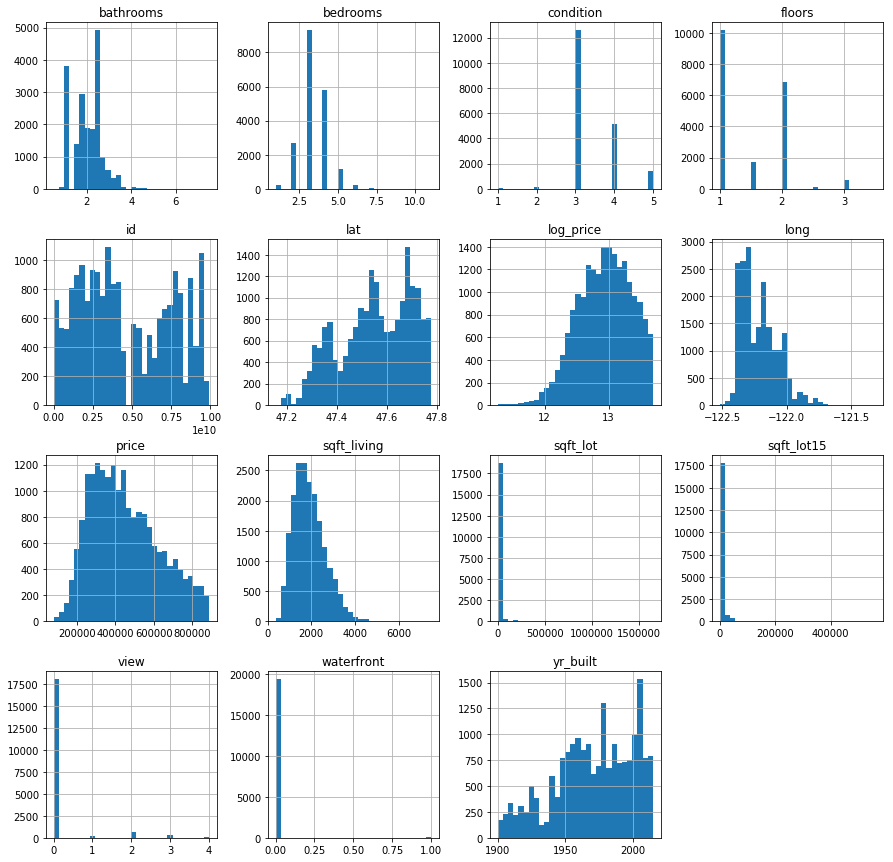

In [42]:
_ = house_data_90.hist(figsize=(15,15), bins=30)

Create a column for distance from downtown Seattle (latitude and longitude provide by Google Maps). We expect it to be a useful predictor as Seattle and it's neighboring cities have a large proportion of job opportunities and higher population density.

In [43]:
downtown_sea = (47.609795, -122.337173) #(lat, lon)

In [44]:
house_data_90['lat_long'] = list(zip(house_data_90['lat'], house_data_90['long']))
house_data_90.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)"
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)"
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)"
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)"
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)"


In [45]:
house_data_90['distance_from_downtown_sea'] = house_data_90['lat_long'].apply(lambda x: haversine(downtown_sea, x, unit='mi'))

In [46]:
house_data_90.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434


The dates in this dataframe range from 2014 to 2015. We may want to adjust the price to account for inflation in 2019. $1 in 2014 is the equivalent of $1.07 in 2019.

In [47]:
house_data_90['2019_price'] = house_data_90['price'].apply(lambda x: x*1.07)
house_data_90.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea,2019_price
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463,237433.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926,575660.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232,192600.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113,646280.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434,545700.0


In [70]:
predictors = house_data_90.columns
predictors = list(predictors)
predictors.remove('date')
predictors.remove('price')
predictors.remove('log_price')
predictors.remove('lat_long')
predictors.remove('2019_price')
predictors

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_lot15',
 'distance_from_downtown_sea']

In [71]:
predictor_mae = {}
for predictor in predictors:
    x = house_data_90[[predictor]]
    y = house_data_90['log_price']
    predictor_mae[predictor] = test_median_err(x,y)

sorted_predictor_mae = sorted(predictor_mae.items(), key=lambda x :x[1])
sorted_predictor_mae

[('lat', 100859.15610694536),
 ('sqft_living', 106863.5865112133),
 ('distance_from_downtown_sea', 112355.70750538676),
 ('bathrooms', 115506.92919909519),
 ('sqft_basement', 122223.68456124744),
 ('floors', 123624.88765366464),
 ('bedrooms', 123762.78237633403),
 ('view', 124417.35070289539),
 ('condition', 126340.9112928538),
 ('sqft_lot15', 126450.61122191639),
 ('sqft_lot', 126519.21905472779),
 ('id', 126664.1567689757),
 ('waterfront', 126862.00856505668),
 ('long', 126887.43300092072),
 ('yr_built', 127389.02615928403)]

In [72]:
X1 = house_data_90[['sqft_living', 'bedrooms', 'bathrooms']]
X2 = house_data_90[['lat', 'sqft_living']]
y = house_data_90['log_price']

In [73]:
test_median_err(X1,y)

105563.49502870669

In [74]:
test_median_err(X2,y)

72599.168362367

In [75]:
X3 = house_data_90[['distance_from_downtown_sea', 'sqft_living']]
test_median_err(X3, y)

81014.70533651744

In [76]:
X4 = house_data_90[['sqft_living', 'lat']]
test_median_err(X4, y)

72674.49352862223

In [77]:
X5 = house_data_90[['sqft_living', 'lat', 'bathrooms']]
test_median_err(X5, y)

71988.638443149

In [78]:
X6 = house_data_90[['lat', 'bathrooms']]
test_median_err(X6, y)

84548.98988340449

In [79]:
X7 = house_data_90[['sqft_living', 'distance_from_downtown_sea']]
test_median_err(X7, y)

81169.55236071479

In [80]:
X8 = house_data_90[['sqft_living', 'lat']]
test_median_err(X4, y)

72458.29386658911

In [81]:
X9 = house_data_90[['long', 'lat']]
test_median_err(X9, y)

98610.04290197405

In [60]:
# target = house_data_90['log_price']

# for i in range(len(sorted_predictor_mae)):
#     predictors = []
#     for predictor in sorted_predictor_mae[:i+1]:
#         name = predictor[0]
#         predictors.append(house_data_90[name]) 
#     print(predictors, target)
#         #    test_median_err(predictors, target)

[0        47.5112
1        47.7210
2        47.7379
3        47.5208
4        47.6168
6        47.3097
8        47.5123
9        47.3684
10       47.6007
11       47.6900
12       47.7558
13       47.6127
14       47.6700
15       47.5714
16       47.7277
17       47.6648
18       47.3089
19       47.3343
20       47.7025
22       47.3266
23       47.3533
24       47.3739
25       47.3048
27       47.6221
28       47.6950
29       47.7073
30       47.5391
31       47.7274
32       47.6823
33       47.6889
          ...   
21561    47.5869
21562    47.5925
21563    47.6374
21564    47.5184
21565    47.5184
21566    47.6785
21567    47.6413
21568    47.5621
21569    47.3339
21570    47.6707
21571    47.7337
21572    47.6756
21573    47.3452
21575    47.5001
21576    47.6542
21578    47.3749
21579    47.6533
21580    47.4822
21582    47.2931
21583    47.6857
21585    47.6963
21586    47.3095
21587    47.5389
21588    47.5699
21591    47.5773
21592    47.6993
21593    47.5107
21594    47.5

In [82]:
def kfolds(data, k):
    """Convert data to a dataframe and construct k-tolds for train-test"""
    # create a dataframe from the data
    df = pd.DataFrame(data)
    
    #find the number of rows in the data frame
    num_observations = len(df)
    
    # determine how large the folds are as well as how much leftover
    rows_in_folds = num_observations//k #floor division
    leftover_rows = num_observations%k
    
    folds = [] #make a list of fold sizes
    starting_row = 0  # start the fold at this row
    for i in range(k):
        if leftover_rows > 0:
            folds.append(df.iloc[starting_row : starting_row+rows_in_folds+1])
            leftover_rows -= 1
            starting_row += rows_in_folds + 1
        else:
            folds.append(df.iloc[starting_row : starting_row+rows_in_folds])
            starting_row += rows_in_folds
         
    return folds

In [83]:
def mae_for_kfolds(X, y, data, k):   #X is a list of predictor names. y is a list of the target name
    """Constructs an array of MAE values for k folds of data"""
    folds = kfolds(data, k) #constructs kfolds
    
    test_errs = []
    train_errs = []
    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i,fold in enumerate(folds) if i != n])
        test = folds[n]
        # Fit a linear regression model
        linreg = LinearRegression()
        test_err = []
        linreg.fit(train[X], train[y])
        #Evaluate Train and Test Errors
        y_hat_test = linreg.predict(test[X])
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(test[y])
        test_errs.append(median_absolute_error(invert_y_test, invert_y_hat_test))
    return test_errs

In [84]:
X10 = ['lat','sqft_living', 'bathrooms']
y = ['log_price']
mae_for_kfolds(X10, y, house_data_90, 10)

[73102.38934823862,
 74832.904648553,
 76611.20157705201,
 67908.23147085655,
 72100.15816549904,
 73869.84717792703,
 71836.03606251936,
 73078.53634080308,
 72359.0212302646,
 63135.32681806732]

One method to select factors.

In [85]:
# X and y are dataframes with specific columns

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [92]:
result = stepwise_selection(house_data_90[X10], house_data_90['log_price'], verbose = True)
print('resulting features:')
print(result)

Add  lat                            with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
resulting features:
['lat', 'bathrooms', 'sqft_living']


Another potential way to select factors

In [66]:
from sklearn.feature_selection import RFE

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 3)
selector = selector.fit(house_data_90[X10], house_data_90['log_price'])

In [67]:
print(X10)
print(selector.support_)
print(selector.ranking_)

['lat', 'sqft_living', 'bathrooms']
[ True  True  True]
[1 1 1]


In [68]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[1.47198837e+00 2.92549744e-04 5.33930534e-02]
-57.7294708395994


In [104]:
selector2 = RFE(linreg, n_features_to_select = 5)
selector2 = selector2.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector2.support_)
print(selector2.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False False  True False False False  True  True False False False  True
  True False False]
[11  4  1  7  9  3  1  1  2  8  6  1  1 10  5]


In [ ]:
X11 = ['bathrooms','waterfront', 'lat']
X11_mae = mae_for_kfolds(X11, y, house_data_90, 10)

print(X11_mae)
np.mean(X11_mae)

In [ ]:
selector4 = RFE(linreg, n_features_to_select = 4)
selector4 = selector4.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector4.support_)
print(selector4.ranking_)

In [ ]:
X12 = ['bathrooms','waterfront', 'lat', 'long']
X12_mae = mae_for_kfolds(X12, y, house_data_90, 10)

print(X12_mae)
np.mean(X12_mae)

In [ ]:
selector5 = RFE(linreg, n_features_to_select = 5)
selector5 = selector5.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector5.support_)
print(selector5.ranking_)

In [ ]:
X13 = ['bathrooms','waterfront', 'view', 'lat', 'long']
X13_mae = mae_for_kfolds(X13, y, house_data_90, 10)

print(X13_mae)
np.mean(X13_mae)

In [105]:
outcome = 'log_price'
preds = house_data_90.loc[:, ['bathrooms', 'waterfront', 'view', 'lat', 'long']]
preds_int = sm.add_constant(preds)
model = sm.OLS(np.asarray(house_data_90['log_price']), np.asarray(preds_int)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     3466.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:08:01   Log-Likelihood:                -4276.6
No. Observations:               19380   AIC:                             8565.
Df Residuals:                   19374   BIC:                             8612.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.8436      1.980    -19.108      0.000     -41.725     -33.962
x1             0.2529      0.003     77.504      0.000       0.246       0.259
x2             0.2057      0.050      4.136      0.000       0.108       0.303
x3             0.1187      0.004     30.710      0.000       0.111       0.126
x4             1.5148      0.015     98.811      0.000       1.485       1.545
x5             0.1782      0.016     11.218      0.000       0.147       0.209
==============================================================================
Omnibus:                      111.388   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.014
Skew:                          -0.114   Prob(JB):                     2.92e-30
Kurtosis:                       3.341   Cond. No.                     1.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""